# Creating a Decision Tree to Predict Outcome for Animal Shelter

In this notebook, I will create a decision tree in order to predict certain outcomes for the Austin Animal Shelter. The model itself should help in determining what may happen to an animal when it comes in. Additionally, by examining the data and the model itself, I will examine opportunities to help with more positive outcomes (such as an animal being adopted), or minimize negative outcomes (such as animals not being adopted, necessitating a transfer to another facility). For this reason, I will use a decision tree classifier as my model, since it is more interpretable than black box models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix

## Early Data Analysis

To start, I need to examine the data available. The first thing that is noticable is that most of the data is catagorical, rather than numerical. I will see what data can be updated to a numeric stat, and otherwise reformat the categories into a more numerically friendly way. The data appears to be mostly filled in, except for significant empty values in outcome_subtype and name. I ultimately will not use outcome_subtype in my model, as it will inherently be too linked with the target, outcome_type. I will return to names later.

In [2]:
df = pd.read_csv('aac_shelter_outcomes.csv')

In [3]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


In [5]:
df.isna().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [ ]:
df.fillna({'name': 'none', 'outcome_subtype': 'N/A'}, inplace=True)
df.dropna(inplace=True)

## The Target: outcome_type

I ultimately want to know what the outcome for a given animal will be. On investigation, the 4 outcomes with notable data points are Adoption, Return to Owner, Transfer and Euthanasia. Ideally we would like to get animals adopted or returned as much as possible, and avoid needing to transfer an animal or euthanize an animal. On further investigation into euthanization, however, I found that there unfortunately the reasons for Euthanasia were pretty immutable (There is no realistic intervention an animal shelter could take to cure extreme medical issues, or solve extreme behavioral issues). As such, I limited the model to adoption, transfer, and return to owner data.

In [6]:
df['outcome_type'].value_counts(normalize=True)

Adoption           0.423189
Transfer           0.300330
Return to Owner    0.183452
Euthanasia         0.077706
Died               0.008691
Disposal           0.003924
Rto-Adopt          0.001917
Missing            0.000588
Relocate           0.000204
Name: outcome_type, dtype: float64

In [7]:
df.loc[df['outcome_type']=='Rto-Adopt', 'outcome_type'] = 'Return to Owner'

In [8]:
df = df[ (df['outcome_type']=='Adoption') | (df['outcome_type']=='Transfer') | (df['outcome_type']=='Return to Owner') \
        | (df['outcome_type']=='Euthanasia')]

In [9]:
df_euthanized = df[df['outcome_type']=='Euthanasia']

df_euthanized['outcome_subtype'].value_counts()

Suffering              2514
Rabies Risk            2417
Aggressive              506
Medical                 259
Behavior                142
Underage                 28
At Vet                   26
Court/Investigation      18
Name: outcome_subtype, dtype: int64

In [10]:
df = df[df['outcome_type']!= 'Euthanasia']

## Animal Types

There does not appear to be many data points for animals outside of dogs and cats. The only other category with a significant number is "Other". As such, we will limit the model to only cats and dogs.

In [11]:
df['animal_type'].value_counts()

Dog          42562
Cat          27519
Other          810
Bird           215
Livestock        9
Name: animal_type, dtype: int64

In [12]:
catsdogs = df[ (df['animal_type']!='Dog') & (df['animal_type']!='Cat')].index
df.drop(catsdogs, inplace=True)

## Temporal Data

I theorize that there may be trends when adoption spikes (such as in the summer when people would be more willing to walk dogs, or around Christmas when families would be excited to get a new pet). It appears that not all months are covered in 2013 or 2018, so I excluded those years from the data to not artifically inflate the months counted in those years vs those not counted in those years. It does appear that adoption does tend to come in waves based on the data.

In [13]:
df['year'] = pd.DatetimeIndex(df['monthyear']).year
df['month'] = pd.DatetimeIndex(df['monthyear']).month
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,year,month
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2014,7
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,2013,11
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,2014,6
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,2014,6
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male,2013,10


In [14]:
df['year'].value_counts(normalize=True)

2015    0.236797
2014    0.234001
2017    0.228721
2016    0.228136
2013    0.056549
2018    0.015796
Name: year, dtype: float64

In [15]:
df['month'].value_counts()

10    6954
7     6770
12    6390
11    6383
6     6224
8     6163
5     6092
9     5837
1     5808
4     4807
3     4422
2     4231
Name: month, dtype: int64

In [16]:
df_years = df[ (df['year'] > 2013) & (df['year'] < 2018) ]

In [17]:
df_years['month'].value_counts()

7     6770
6     6224
8     6163
5     6092
9     5837
10    5531
11    5196
12    5037
4     4807
1     4731
3     4422
2     4201
Name: month, dtype: int64

In [18]:
df = df[(df.year > 2013) & (df.year < 2018)]

In [19]:
df['year'].value_counts()

2015    16595
2014    16399
2017    16029
2016    15988
Name: year, dtype: int64

In [20]:
monthname = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df['month'] = df['month'].replace(monthname)

In [21]:
CrosstabResult=pd.crosstab(index=df['month'],columns=df['outcome_type'], normalize='index')

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

CrosstabResult = CrosstabResult.reindex(month_order)
CrosstabResult

outcome_type,Adoption,Return to Owner,Transfer
month,,,
Jan,0.497569,0.236525,0.265906
Feb,0.499405,0.241609,0.258986
Mar,0.425147,0.275667,0.299186
Apr,0.370293,0.243395,0.386312
May,0.396914,0.215036,0.388050
Jun,0.468670,0.170308,0.361022
Jul,0.535894,0.149778,0.314328
Aug,0.499108,0.163557,0.337336
Sep,0.447148,0.185369,0.367483


## Cats Vs Dogs

We all know that there are cat people and dog people. However, I did not know whether we would see similar distrubutions of outcomes for each animal. As turns out, that is not the case. It turns out dogs tend to have more adoptions than transfers, while cats have about an equal number of adoptions and transfers. Additionally, dogs have a much better chance of getting returned to their owners.

In [73]:
df['animal_type'].value_counts()

Dog    39306
Cat    25705
Name: animal_type, dtype: int64

In [24]:
df.groupby(['animal_type', 'outcome_type']).size()

animal_type  outcome_type   
Cat          Adoption           11805
             Return to Owner     1363
             Transfer           12537
Dog          Adoption           18557
             Return to Owner    12059
             Transfer            8690
dtype: int64

In [25]:
df_cats = df[df['animal_type']=='Cat']
df_dogs = df[df['animal_type']=='Dog']

In [26]:
cat_labels = df_cats['outcome_type'].value_counts().index
cat_nums = df_cats['outcome_type'].value_counts().values
cat_labels

Index(['Transfer', 'Adoption', 'Return to Owner'], dtype='object')

In [27]:
dog_labels = df_dogs['outcome_type'].value_counts().index
dog_nums = df_dogs['outcome_type'].value_counts().values

In [28]:
cat_labels == dog_labels

array([False, False, False])

In [29]:
print(cat_labels)
print(dog_labels)

Index(['Transfer', 'Adoption', 'Return to Owner'], dtype='object')
Index(['Adoption', 'Return to Owner', 'Transfer'], dtype='object')


In [30]:
#Dog order is better, moving cat order around
listorder = [1,2,0]
cat_nums[:] = [cat_nums[i] for i in listorder]
cat_nums

array([11805,  1363, 12537])

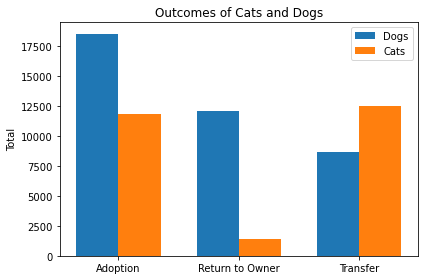

In [31]:
fig, ax = plt.subplots()

x = np.arange(len(dog_labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, dog_nums, width, label='Dogs')
rects2 = ax.bar(x + width/2, cat_nums, width, label='Cats')

ax.set_ylabel('Total')
ax.set_title('Outcomes of Cats and Dogs')
plt.xticks(x, dog_labels)
ax.legend()

fig.tight_layout()

plt.show()

## Age

Age is really the only feature I have that will realistically be on a numerical scale. After converting to an integer (in part by simplifiying the data to only be in years rather than days, weeks, months and years), we find that most animals are very young. My initial theoy would be that younger animals tended to get adopted more, while older animals are transferred, but the boxplots look roughly the same for each category. Animals returned to owners did seem to skew older.

In [32]:
df['age_upon_outcome'].value_counts()

1 year       10933
2 years       9066
2 months      8355
3 years       4329
3 months      3036
1 month       2780
4 years       2543
5 years       2306
4 months      2105
6 years       1594
5 months      1548
3 weeks       1371
6 months      1359
7 years       1343
8 years       1337
2 weeks       1208
10 months     1059
8 months      1029
10 years       961
7 months       855
4 weeks        738
9 years        701
9 months       576
12 years       468
1 weeks        448
11 months      427
1 week         384
11 years       362
13 years       307
3 days         213
14 years       197
2 days         191
15 years       153
6 days         138
1 day          125
4 days         119
5 days          89
16 years        74
0 years         61
5 weeks         48
17 years        42
18 years        16
19 years         8
20 years         6
22 years         3
Name: age_upon_outcome, dtype: int64

In [33]:
def age_number(row):
    if 'day' in row or 'week' in row or 'month' in row or row == '0 years':
        return 0
    elif row == '1 year':
        return 1
    else:
        return row[:-6]

In [34]:
df['age_number'] = df.apply(lambda row: age_number(row['age_upon_outcome']), axis=1)

In [35]:
df['age_number'] = df['age_number'].astype('int64')

<AxesSubplot:>

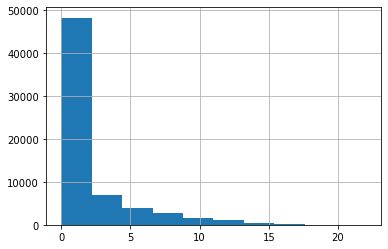

In [36]:
df['age_number'].hist();;

<AxesSubplot:xlabel='age_number', ylabel='outcome_type'>

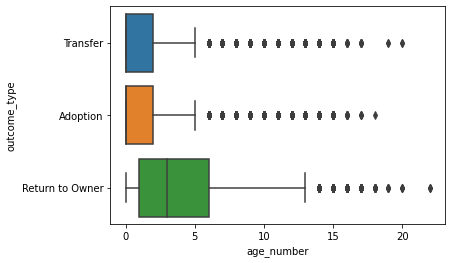

In [37]:
sns.boxplot(x=df['age_number'], y=df['outcome_type']);

## Color

Color was particularly difficult to handle for two reasons:

1. There was a pretty long lists of colors and color combinations, making it diffcult to consolidate into larger more generic groups, especially without knowing a "primary color" for a given animal.
2. Some color descriptions would overlap with animal breed (ie Calicos would only be cats)

I still felt that this could be a valuable metric in the model, so I standardized as much as possible (by consolidating similar color descriptions and re-classifying animal specific mentions into the most commmon colors. From there I tabulated colors that appeared the most.

In [39]:
df['color'].value_counts()[0:30]

Black/White            6969
Black                  5557
Brown Tabby            3921
White                  2341
Tan/White              2140
Brown/White            2091
Brown Tabby/White      2044
Orange Tabby           1917
Blue/White             1834
White/Black            1777
Tricolor               1732
Tan                    1732
Black/Tan              1615
Brown                  1613
White/Brown            1341
Black/Brown            1245
Brown Brindle/White    1199
Calico                 1170
Tortie                 1167
Blue                   1160
White/Tan              1028
Blue Tabby             1004
Orange Tabby/White      952
Brown/Black             874
Red                     796
Red/White               754
Torbie                  739
Brown Brindle           632
Tan/Black               541
Chocolate/White         524
Name: color, dtype: int64

In [40]:
# While color changes will not be 100% accurate, these are most common. Want to make colors dog/cat agnostic

color_change = {
    'Calico': 'White/Orange/Black',
    'Tortie': 'Red/Black',
    'Torbie': 'Brown/Black',
    'Tricolor': 'White/Orange/Black'
}

df.replace(color_change, inplace=True)

In [41]:
df['brown'] = 0
df['black'] = 0
df['white'] = 0
df['orange'] = 0
df['blue'] = 0
df['red'] = 0
df['yellow'] = 0

In [42]:
df.loc[df['color'].str.contains('Black'), 'black'] = 1
df.loc[df['color'].str.contains('Brown'), 'brown'] = 1
df.loc[df['color'].str.contains('White'), 'white'] = 1
df.loc[df['color'].str.contains('Orange'), 'orange'] = 1
df.loc[df['color'].str.contains('Blue'), 'blue'] = 1
df.loc[df['color'].str.contains('Red'), 'red'] = 1
df.loc[df['color'].str.contains('Yellow'), 'yellow'] = 1

In [43]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,year,month,age_number,brown,black,white,orange,blue,red,yellow
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,none,Partner,...,2014,Jul,0,0,0,0,1,0,0,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,N/A,...,2014,Jun,1,0,0,1,0,1,0,0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,2014,Jun,9,0,0,1,0,0,0,0
7,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,...,2014,Dec,3,1,0,0,0,0,0,0
8,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,N/A,...,2014,Aug,0,0,0,1,0,1,0,0


# Spay and Neutering

This information actually gives two ppieces of data in one: the sex, and whether the animal was spayed or neutered. The findings here are pretty interesting:

1. Adopted animals are much more likely to be spayed/neutered than in tact
2. Males in general tended to be returned to owners more than females. Such a significant sex inmbalance did not seem to hold true for adoption or transfer.
3. There was not as much as a disparity in transfers between intact and spayed/neutered animals as adoptions. This isn't to say that there was no difference, simply that it is not as dramatic.

In [74]:
CrosstabResult=pd.crosstab(index=df['outcome_type'],columns=df['sex_upon_outcome'], normalize='index')

CrosstabResult

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
outcome_type,,,,,
Adoption,0.022166,0.017720,0.483565,0.476517,0.000033
Return to Owner,0.088586,0.141484,0.436746,0.329236,0.003949
Transfer,0.261035,0.241014,0.207801,0.180949,0.109201


## Naming the Animals

While I don't know that a specific name will help animal adoptability, I still think it is useful to see if the animal has a name at all. It does appear that anials with names tended to get transferred far less than animals with names.

In [52]:
df['has_name'] = np.where(df['name'] == 'none', 0, 1)

In [54]:
CrosstabResult=pd.crosstab(index=df['has_name'],columns=df['outcome_type'], normalize='index')

CrosstabResult

outcome_type,Adoption,Return to Owner,Transfer
has_name,,,
0,0.302229,0.024669,0.673102
1,0.524373,0.269713,0.205913


## Getting the Data Model Ready

I now have all of the features that I want for my model. All that is left is formatting them so that they can be used. I'll use one hot encoder to tabulate any categorical information left, and then drop all of the columns from the table that will not be used. Additionally, while most of the data is simply 1 or 0, the years feature is a scale, so I will normalize the numbers so that years does not have undue influence.

In [46]:
df_category = df[['animal_type', 'sex_upon_outcome', 'month']]

In [47]:
df_category

,animal_type,sex_upon_outcome,month
0,Cat,Intact Male,Jul
2,Dog,Neutered Male,Jun
3,Dog,Neutered Male,Jun
7,Dog,Spayed Female,Dec
8,Cat,Intact Female,Aug
...,...,...,...
78225,Dog,Neutered Male,Aug
78227,Dog,Neutered Male,Sep
78231,Cat,Intact Female,Dec
78232,Cat,Intact Male,Sep


In [48]:
ohe = OneHotEncoder()

ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

cat_ohe = pd.DataFrame(ohe.fit_transform(df_category), \
                               columns=ohe.get_feature_names(df_category.columns) ,index=df_category.index)

In [49]:
cat_ohe

,animal_type_Dog,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78225,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78232,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
df = pd.concat([df, cat_ohe], axis=1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65011 entries, 0 to 78244
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_upon_outcome                65011 non-null  object 
 1   animal_id                       65011 non-null  object 
 2   animal_type                     65011 non-null  object 
 3   breed                           65011 non-null  object 
 4   color                           65011 non-null  object 
 5   date_of_birth                   65011 non-null  object 
 6   datetime                        65011 non-null  object 
 7   monthyear                       65011 non-null  object 
 8   name                            65011 non-null  object 
 9   outcome_subtype                 65011 non-null  object 
 10  outcome_type                    65011 non-null  object 
 11  sex_upon_outcome                65011 non-null  object 
 12  year                            

In [56]:
x_data = df.select_dtypes(exclude=['object'])
y_data = df['outcome_type']

In [57]:
x_data.head()

,year,age_number,brown,black,white,orange,blue,red,yellow,animal_type_Dog,...,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,has_name
0,2014,0,0,0,0,1,0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2014,1,0,0,1,0,1,0,0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,2014,9,0,0,1,0,0,0,0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
7,2014,3,1,0,0,0,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,2014,0,0,0,1,0,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [58]:
x_data.drop(columns=['year'], inplace=True)

/Users/georgeferre/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
x_normalized = Normalizer().fit_transform(x_data)

## Building Models

First I will split the data and build a model based on all of my features. In training, I had 77% accuracy, with 65% accuracy on test data, suggesting some overfitting. The confusion matrix seems to heavily rely on guessing adoption, and is more incorrect than correct in predicting Return to Owner.

Looking at the feature importance, It appears that month of outcome and animal colors are not significant factors in the model, and by removing them the model is improved. The new model has a testing score of 70% with a testing score of 68%. This means that it is both more accurate and less prone to overfitting.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(x_normalized, y_data,test_size=0.2, random_state = 1)
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [61]:
dt_clf.score(X_train, y_train)

0.7705929856945085

In [62]:
dt_clf.score(X_test, y_test)

0.6528493424594325

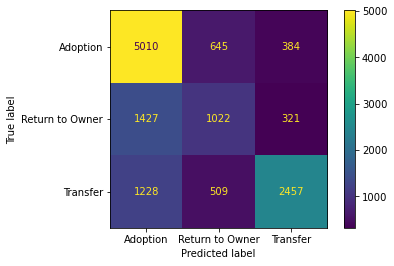

In [63]:
plot_confusion_matrix(dt_clf,X_test,y_test);

In [64]:
for fi, feature in zip(dt_clf.feature_importances_, x_data.columns):
    print(fi, feature)

0.13605840001358502 age_number
0.023311678212297494 brown
0.028139847407352446 black
0.027108878873955137 white
0.010076756764379143 orange
0.018362282138432898 blue
0.013721596262160088 red
0.005515794166958012 yellow
0.06134133238483133 animal_type_Dog
0.0616079066536925 sex_upon_outcome_Intact Male
0.1187023635341684 sex_upon_outcome_Neutered Male
0.13222751716514394 sex_upon_outcome_Spayed Female
0.003028815597047409 sex_upon_outcome_Unknown
0.014254928186523207 month_Aug
0.014206612280112326 month_Dec
0.014405577860944953 month_Feb
0.014030541708773854 month_Jan
0.01134593575272692 month_Jul
0.013112235397223433 month_Jun
0.011950925092088708 month_Mar
0.015638390161605238 month_May
0.013402428541739324 month_Nov
0.01364027162780285 month_Oct
0.013474299641068256 month_Sep
0.21133468457538715 has_name


In [65]:
df_stripped = df[['age_number', 'animal_type_Dog', 'sex_upon_outcome_Intact Male', \
                  'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', \
                  'sex_upon_outcome_Unknown', 'has_name']]

In [66]:
df_stripped

,age_number,animal_type_Dog,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,has_name
0,0,0.0,1.0,0.0,0.0,0.0,0
2,1,1.0,0.0,1.0,0.0,0.0,1
3,9,1.0,0.0,1.0,0.0,0.0,1
7,3,1.0,0.0,0.0,1.0,0.0,1
8,0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
78225,2,1.0,0.0,1.0,0.0,0.0,1
78227,2,1.0,0.0,1.0,0.0,0.0,1
78231,0,0.0,0.0,0.0,0.0,0.0,1
78232,0,0.0,1.0,0.0,0.0,0.0,1


In [67]:
x_stripped_normalized = Normalizer().fit_transform(df_stripped)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x_stripped_normalized, y_data,test_size=0.2, random_state = 1)
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [69]:
dt_clf.score(X_train, y_train)

0.6977003537917243

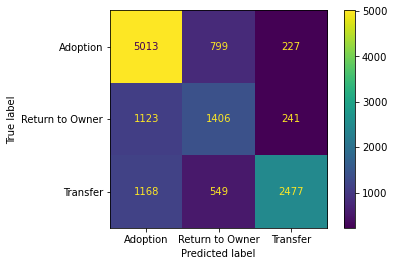

In [70]:
plot_confusion_matrix(dt_clf,X_test,y_test);

In [71]:
for fi, feature in zip(dt_clf.feature_importances_, df_stripped.columns):
    print(fi, feature)

0.18577674386674392 age_number
0.09495524449580242 animal_type_Dog
0.08683651035354398 sex_upon_outcome_Intact Male
0.12600651791671158 sex_upon_outcome_Neutered Male
0.162280169189152 sex_upon_outcome_Spayed Female
0.005915342486959139 sex_upon_outcome_Unknown
0.33822947169108697 has_name


In [72]:
dt_clf.score(X_test, y_test)

0.6841498115819427

## Conclusion

It appears that when determining the outcome for an animal, we should look at the following:

1. What kind of animal it is
2. Whether the animal has a name
3. How old the animal is
4. Sex and fixing status of the animal

To promote positive outcomes, we can possibly do the following:

1. For cats, encourage getting a chip implanted. It is possible that because cats are typically "indoor animals" the fear of losing them may be lower than dogs who must be taken outside.
2. Name animals. It is likely easier to bond with an animal that has a name. The adoptees can always rename an animal if they would like.
3. Run donation drives for fixing animals. They are easier to adopt (the owner does not have to pay vet to do so or worry about dealing with pregnancy), and will help reduce overall population to a more sustainable level.

Future studies:
1. Separate dogs and cats for their own models to get more specific information.
2. Get information on people who adopt so that different groups could be reached abo